In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from scipy.stats import poisson

In [2]:
import plot_utils

In [55]:
# Parameters for the simulation
np.random.seed(42)
num_generations = 20  # Total number of generations to simulate
initial_fitness = 0.0  # Starting fitness for the root lineage
fitness_variation = 0.2  # Standard deviation for fitness evolution (Brownian motion)
lambda_offspring = 10  # Mean number of offspring per generation (Poisson rate)
mutation_rate = 1.0  # Mutation rate per offspring (Poisson)

In [56]:
import numpy as np
import networkx as nx

def initialize_tree(initial_fitness=1.0):
    """Initialize a new phylogenetic tree with a single root node."""
    tree = nx.DiGraph()
    tree.add_node(0, fitness=initial_fitness, generation=0)
    return tree, [0], 1  # tree, current_lineages, next_node_id

def simulate_generation(tree, current_lineages, next_node_id, generation, lambda_offspring, fitness_variation, mutation_rate, selection_strength):
    """Simulate a single generation of offspring allocation and fitness evolution."""
    # Sample total offspring for the generation
    num_offspring = np.random.poisson(lambda_offspring)

    # Calculate fitness-based selection probabilities
    fitnesses = np.array([tree.nodes[lineage]["fitness"] for lineage in current_lineages])
    selection_probs = np.exp(selection_strength * fitnesses) / np.sum(np.exp(selection_strength * fitnesses))

    # Allocate offspring based on selection probabilities
    offspring_counts = np.random.multinomial(num_offspring, selection_probs)

    # Generate offspring and update the tree
    new_lineages = []
    for parent, count in zip(current_lineages, offspring_counts):
        for _ in range(count):
            parent_fitness = tree.nodes[parent]["fitness"]
            offspring_fitness = parent_fitness + np.random.normal(0, fitness_variation)

            # Add offspring node to the tree
            tree.add_node(next_node_id, fitness=offspring_fitness, generation=generation)
            tree.add_edge(parent, next_node_id, mutations=np.random.poisson(mutation_rate))

            # Track the new lineage
            new_lineages.append(next_node_id)
            next_node_id += 1

    return tree, new_lineages, next_node_id

def collect_tip_data(tree):
    """Extract data for tip nodes (final lineages) in the tree."""
    tips = [node for node in tree.nodes if tree.out_degree(node) == 0]
    tip_fitness = np.array([tree.nodes[tip]["fitness"] for tip in tips])
    tip_mutations = np.array([
        sum(tree.edges[edge]["mutations"] for edge in nx.utils.pairwise(nx.shortest_path(tree, 0, tip))) for tip in tips
    ])
    return tips, tip_fitness, tip_mutations

def calculate_contrasts(tree):
    """Calculate branch-level contrasts for fitness and mutations."""
    contrasts_fitness = []
    contrasts_mutations = []

    for edge in tree.edges:
        parent, child = edge
        fitness_change = tree.nodes[child]["fitness"] - tree.nodes[parent]["fitness"]
        mutation_change = tree.edges[edge]["mutations"]
        contrasts_fitness.append(fitness_change)
        contrasts_mutations.append(mutation_change)

    return np.array(contrasts_fitness), np.array(contrasts_mutations)

def simulate_tree(
    num_generations=10, 
    initial_fitness=1.0, 
    fitness_variation=0.2, 
    lambda_offspring=50, 
    mutation_rate=1.0, 
    selection_strength=1.0,
    seed=None
):
    """Simulate a complete phylogenetic tree with fitness-weighted offspring allocation."""
    if seed is not None:
        np.random.seed(seed)

    # Initialize tree and simulation variables
    tree, current_lineages, next_node_id = initialize_tree(initial_fitness)

    # Simulate each generation
    for generation in range(1, num_generations + 1):
        tree, current_lineages, next_node_id = simulate_generation(
            tree, current_lineages, next_node_id, generation, lambda_offspring, fitness_variation, mutation_rate, selection_strength
        )

    # Collect tip and contrast data
    tips, tip_fitness, tip_mutations = collect_tip_data(tree)
    contrasts_fitness, contrasts_mutations = calculate_contrasts(tree)

    return tree, tips, tip_fitness, tip_mutations, contrasts_fitness, contrasts_mutations

# Example usage
tree, tips, tip_fitness, tip_mutations, contrasts_fitness, contrasts_mutations = simulate_tree(
    num_generations=num_generations, 
    initial_fitness=initial_fitness, 
    fitness_variation=fitness_variation, 
    lambda_offspring=lambda_offspring, 
    mutation_rate=mutation_rate, 
)

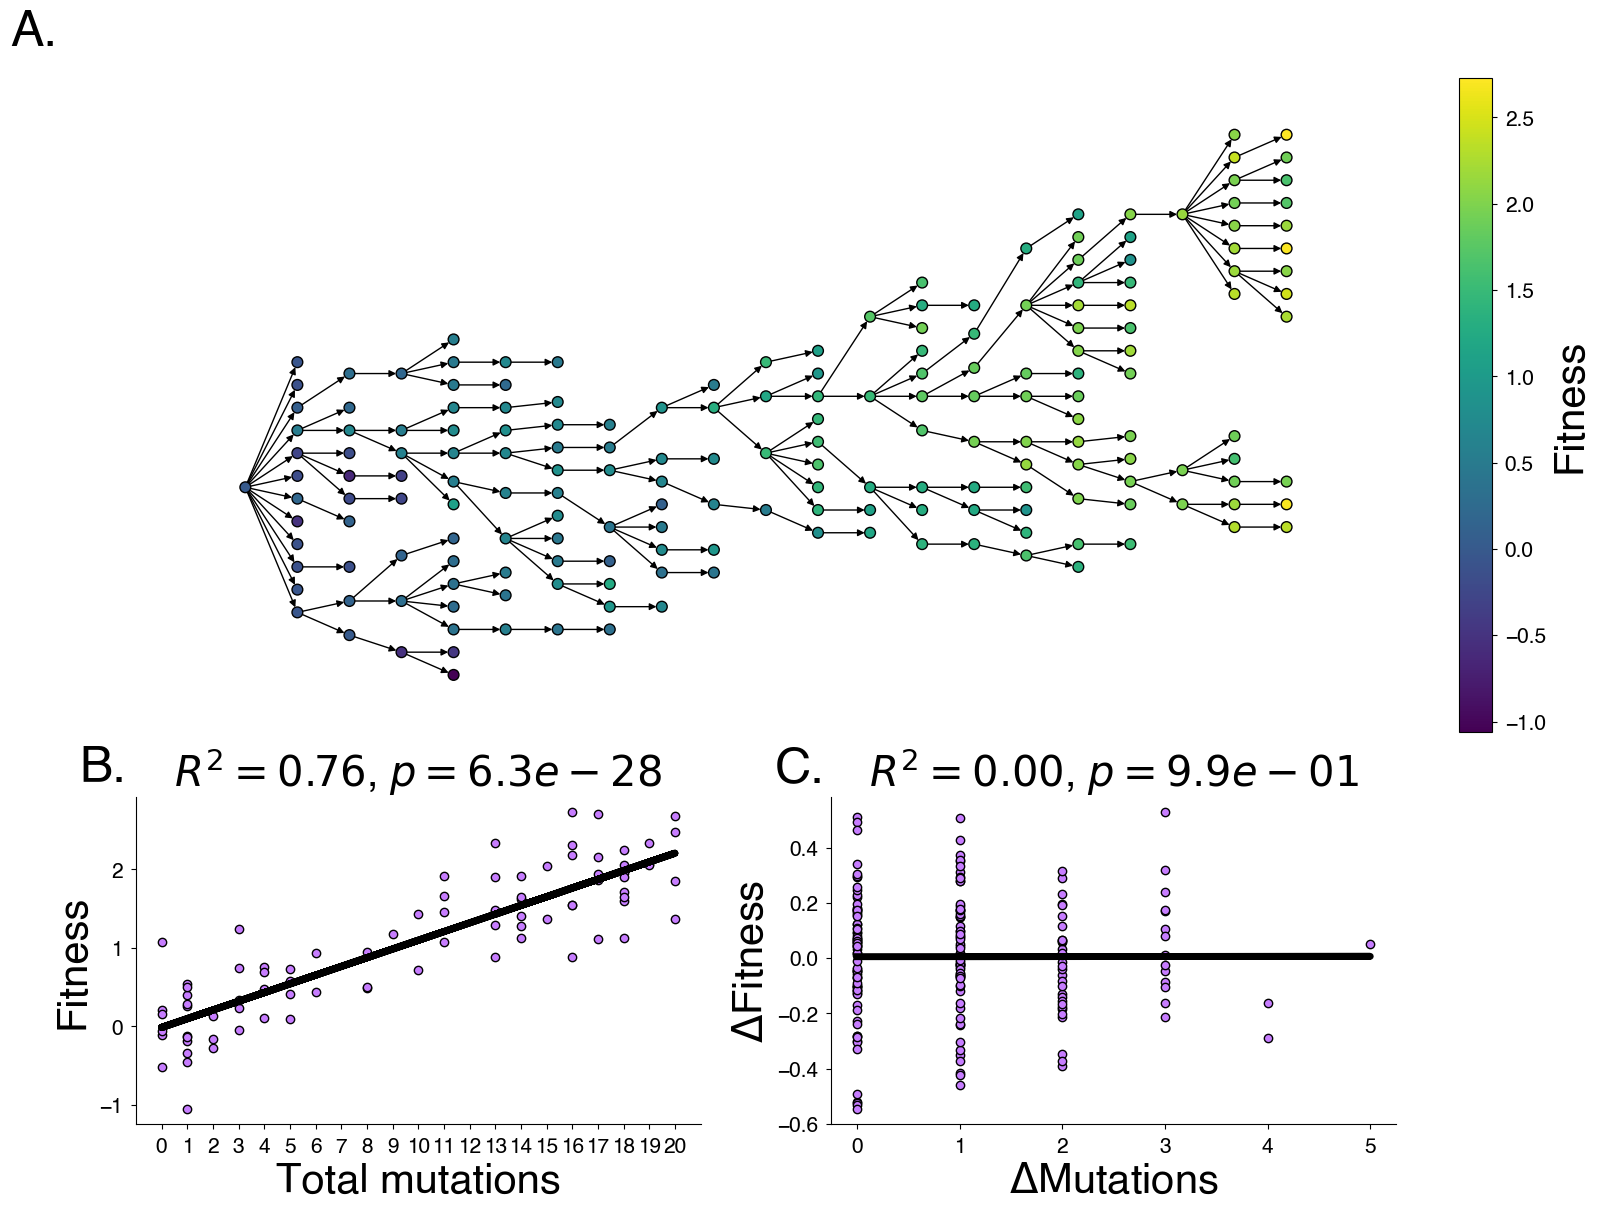

In [60]:
from scipy.stats import linregress
import string

SCATTER_PLOT_COLOR = "#c77dff"

# Calculate R^2 and p-values for both regressions
# Tip-level regression (Panel B)
slope_tip, intercept_tip, r_value_tip, p_value_tip, _ = linregress(tip_mutations, tip_fitness)

# Contrast-level regression (Panel C)
slope_contrast, intercept_contrast, r_value_contrast, p_value_contrast, _ = linregress(contrasts_mutations, contrasts_fitness)

# Create the figure with gridspec
fig = plt.figure(figsize=(16, 12), constrained_layout=True)
spec = fig.add_gridspec(ncols=2, nrows=2, height_ratios=[2, 1])

# Panel A: Phylogenetic tree
ax_panel_a = fig.add_subplot(spec[0, :])
pos = nx.nx_agraph.graphviz_layout(tree, prog="dot")
pos = {node: (-y, x) for node, (x, y) in pos.items()}

node_colors = [tree.nodes[node]["fitness"] for node in tree.nodes]
nx.draw(
    tree, pos, ax=ax_panel_a, with_labels=False, node_size=60, 
    edge_color="k", node_color=node_colors, edgecolors="k", cmap="viridis"
)
sm = plt.cm.ScalarMappable(cmap="viridis", norm=plt.Normalize(vmin=min(node_colors), vmax=max(node_colors)))
sm.set_array([])
fig.colorbar(sm, ax=ax_panel_a, label="Fitness")

# Panel B: Naive regression
ax_panel_b = fig.add_subplot(spec[1, 0])
ax_panel_b.scatter(tip_mutations, tip_fitness, label="Tip Data", color=SCATTER_PLOT_COLOR, ec="k", marker="o")
naive_fit_line = slope_tip * tip_mutations + intercept_tip
ax_panel_b.plot(tip_mutations, naive_fit_line, color="k")
ax_panel_b.set_xticks(range(int(min(tip_mutations)), int(max(tip_mutations)) + 1))
ax_panel_b.set_title(f"$R^2 = {r_value_tip**2:.2f}$, $p = {p_value_tip:.1e}$")
ax_panel_b.set_ylabel("Fitness")
ax_panel_b.set_xlabel("Total mutations")
ax_panel_b.grid(False)

# Panel C: Branch-level contrast regression
ax_panel_c = fig.add_subplot(spec[1, 1])
ax_panel_c.scatter(contrasts_mutations, contrasts_fitness, label="Branch Contrasts", color=SCATTER_PLOT_COLOR, ec="k", marker="o")
contrast_fit_line = slope_contrast * contrasts_mutations + intercept_contrast
ax_panel_c.plot(contrasts_mutations, contrast_fit_line, color="k")
ax_panel_c.set_xticks(range(int(min(contrasts_mutations)), int(max(contrasts_mutations)) + 1))
ax_panel_c.set_title(f"$R^2 = {r_value_contrast**2:.2f}$, $p = {p_value_contrast:.1e}$")

ax_panel_c.set_ylabel(r"$\Delta$"+"Fitness")
ax_panel_c.set_xlabel(r"$\Delta$"+"Mutations")
ax_panel_c.grid(False)

# Add panel labels
axes = [ax_panel_a, ax_panel_b, ax_panel_c]
ax_labels = string.ascii_uppercase 

for ax, ax_label in zip(axes, ax_labels):
    ax.text(-0.1, 1.05, ax_label + ".", transform=ax.transAxes, size=36, weight='bold')

In [61]:
fig.savefig("../manuscript/figures/synthetic-spurious-correlations.png")

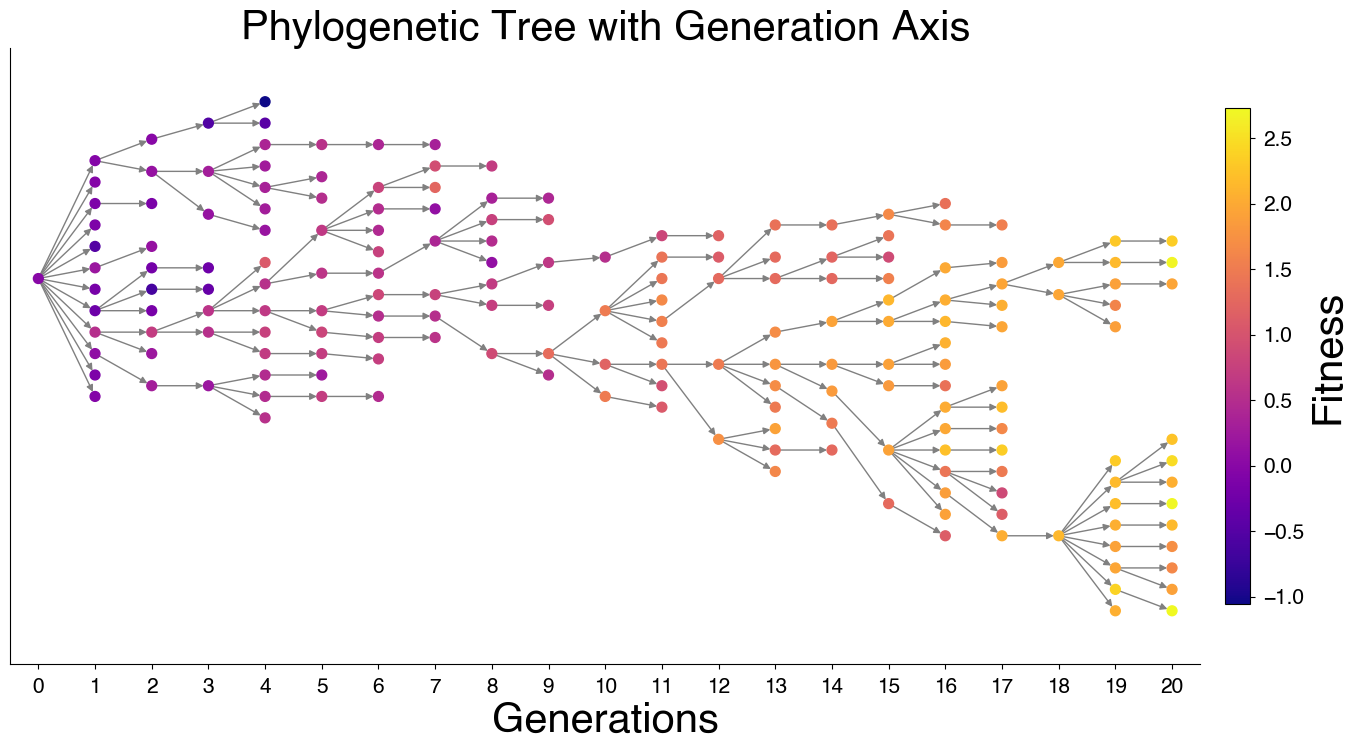

In [59]:
def plot_tree_with_inline_generation_axis(tree, title="Phylogenetic Tree with Generation Axis"):
    """Plots a phylogenetic tree with nodes aligned by generation, including an inline generation axis."""
    # Extract positions based on node generation
    generations = nx.get_node_attributes(tree, "generation")
    pos = nx.nx_agraph.graphviz_layout(tree, prog="dot")

    # Modify positions to align nodes by generation (horizontal layout)
    pos_with_generations = {node: (generations[node], -x) for node, (x, y) in pos.items()}

    # Node colors based on fitness
    node_colors = [tree.nodes[node]["fitness"] for node in tree.nodes]

    # Plot the tree with generations on the x-axis
    plt.figure(figsize=(16, 8))
    ax = plt.gca()
    nx.draw(
        tree, pos=pos_with_generations,
        with_labels=False, node_size=50,
        edge_color="gray", node_color=node_colors, cmap="plasma", ax=ax
    )

    # Add generation axis
    max_generation = max(generations.values())
    ax.set_xlim(-0.5, max_generation + 0.5)
    ax.set_xticks(range(max_generation + 1))
    ax.set_xlabel("Generations")
    ax.set_title(title)
    limits=plt.axis('on') # turns on axis
    ax.tick_params(bottom=True, labelbottom=True, left=False, labelleft=False)

    # Add colorbar for fitness
    sm = plt.cm.ScalarMappable(cmap="plasma", norm=plt.Normalize(vmin=min(node_colors), vmax=max(node_colors)))
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, orientation="vertical", fraction=0.02, pad=0.02)
    cbar.set_label("Fitness")

    plt.show()

# Example usage
plot_tree_with_inline_generation_axis(tree)

In [103]:
import pandas as pd

def simulate_correlation_over_fitness_variation(
    num_generations=20,
    initial_fitness=0.0,
    lambda_offspring=10,
    mutation_rate=1.0,
    selection_strength=1.0,
    fitness_variation_range=np.linspace(0.1, 1.0, 10),
    num_replicates=10,
    seed=None
):
    """
    Simulates trees and calculates correlations over a range of fitness_variation values.

    Parameters:
        num_generations (int): Total number of generations to simulate.
        initial_fitness (float): Starting fitness for the root lineage.
        lambda_offspring (float): Mean number of offspring per generation (Poisson rate).
        mutation_rate (float): Mutation rate per offspring (Poisson).
        selection_strength (float): Strength of selection on fitness.
        fitness_variation_range (array-like): Range of fitness_variation values to simulate.
        num_replicates (int): Number of replicates for each fitness_variation value.
        seed (int, optional): Seed for reproducibility.

    Returns:
        DataFrame: A DataFrame with fitness_variation, replicate, R^2_tip, R^2_contrast for each simulation.
    """
    if seed is not None:
        np.random.seed(seed)

    results = []

    for fitness_variation in fitness_variation_range:
        for replicate in range(num_replicates):
            # Simulate the tree
            tree, _, tip_fitness, tip_mutations, contrasts_fitness, contrasts_mutations = simulate_tree(
                num_generations=num_generations,
                initial_fitness=initial_fitness,
                fitness_variation=fitness_variation,
                lambda_offspring=lambda_offspring,
                mutation_rate=mutation_rate,
                selection_strength=selection_strength,
                seed=None  # Different random seed per replicate
            )

            # Calculate tip-level regression R^2
            tip_slope, tip_intercept, r_value_tip, _, _ = linregress(tip_mutations, tip_fitness)
            r_squared_tip = r_value_tip**2

            # Calculate contrast-level regression R^2
            contrast_slope, contrast_intercept, r_value_contrast, _, _ = linregress(contrasts_mutations, contrasts_fitness)
            r_squared_contrast = r_value_contrast**2

            # Record results
            results.append({
                "fitness_variation": fitness_variation,
                "replicate": replicate,
                "R^2_tip": r_squared_tip,
                "R^2_contrast": r_squared_contrast,
            })

    return pd.DataFrame(results)

# Example usage
fitness_variation_range = np.linspace(0.01, 1.0, 10)  # Vary fitness_variation from 0.1 to 1.0
df_results = simulate_correlation_over_fitness_variation(
    fitness_variation_range=fitness_variation_range,
    num_replicates=500,
)



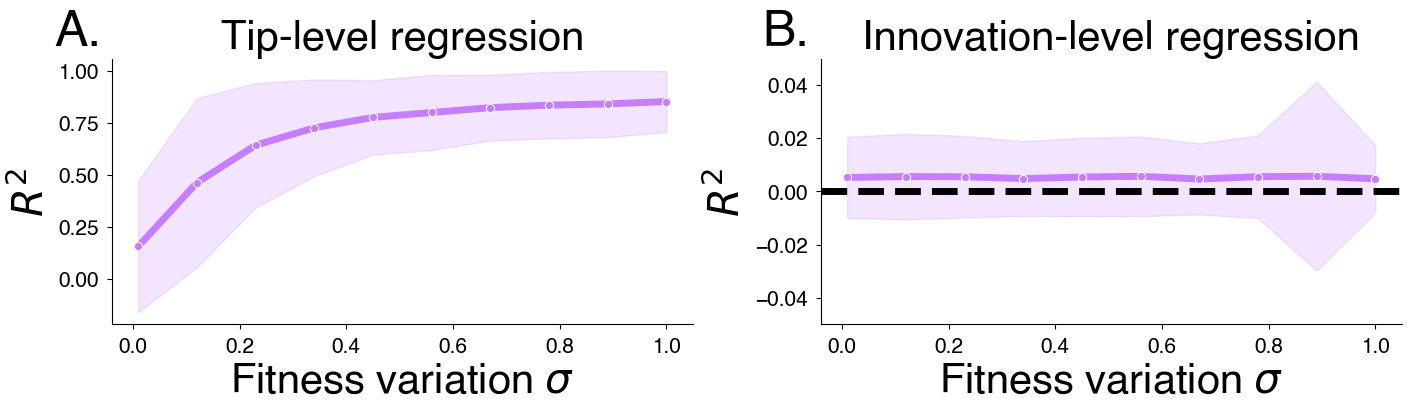

In [104]:
import matplotlib.pyplot as plt
import seaborn as sns
import string

def plot_correlation_vs_fitness_variation(df_results):
    """
    Plots R^2 values from tip-level and contrast-level regressions against fitness variation,
    including uncertainty as confidence intervals.

    Parameters:
        df_results (pd.DataFrame): DataFrame containing fitness_variation, R^2_tip, and R^2_contrast values.
    """
    # Define scatter plot color
    SCATTER_PLOT_COLOR = "#c77dff"

    # Create the figure
    fig = plt.figure(figsize=(14, 4), constrained_layout=True)
    spec = fig.add_gridspec(ncols=2, nrows=1)

    # Panel A: Tip-level R^2 vs Fitness Variation
    ax_panel_a = fig.add_subplot(spec[0, 0])
    sns.lineplot(
        data=df_results, x="fitness_variation", y="R^2_tip", marker="o", ax=ax_panel_a,
        color=SCATTER_PLOT_COLOR, errorbar=("sd", 2)
    )
    ax_panel_a.set_title("Tip-level regression")
    ax_panel_a.set_xlabel("Fitness variation " + r"$\sigma$")
    ax_panel_a.set_ylabel(r"$R^2$")
    ax_panel_a.grid(False)

    # Panel B: Contrast-level R^2 vs Fitness Variation
    ax_panel_b = fig.add_subplot(spec[0, 1])
    sns.lineplot(
        data=df_results, x="fitness_variation", y="R^2_contrast", marker="o", ax=ax_panel_b,
        color=SCATTER_PLOT_COLOR, errorbar=("sd", 2)
    )
    ax_panel_b.axhline(y=0.0, color="k", linestyle="--")
    ax_panel_b.set_title("Innovation-level regression")
    ax_panel_b.set_xlabel("Fitness variation " + r"$\sigma$")
    ax_panel_b.set_ylabel(r"$R^2$")
    ax_panel_b.grid(False)
    ax_panel_b.set_ylim(-0.05, 0.05)

    # Add panel labels
    axes = [ax_panel_a, ax_panel_b]
    ax_labels = string.ascii_uppercase

    for ax, ax_label in zip(axes, ax_labels):
        ax.text(-0.1, 1.05, ax_label + ".", transform=ax.transAxes, size=36, weight='bold')
    return fig

fig = plot_correlation_vs_fitness_variation(df_results)
fig.savefig("../manuscript/supplementary_figures/synthetic-fitness-variation-correlation.png")